C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\1328164291.py:22: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\1328164291.py:39: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),


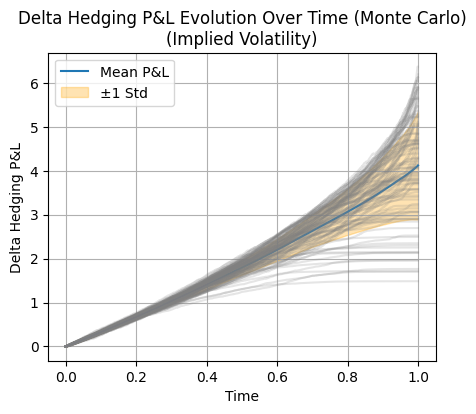

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
S0 = 100      # 初始标的价格
K = 100       # 期权执行价
r = 0.01      # 无风险利率
sigma_iv = 0.3   # 隐含波动率（用于定价和对冲）
T = 1.0       # 到期时间（年）
N = 2520       # 对冲步数（交易日）
M = 100      # 蒙特卡洛路径数

dt = T / N

def bs_delta(S, K, r, sigma, tau):
    """欧式看涨期权BS Delta，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    delta = norm.cdf(d1)
    # 到期时，S > K 为1，否则为0
    if S.ndim == 2:
        delta = np.where(tau > 0, delta, (S > K).astype(float))
    else:
        delta = np.where(tau > 0, delta, 1.0 * (S > K))
    return delta

def bs_price(S, K, r, sigma, tau):
    """欧式看涨期权BS价格，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    d2 = d1 - sigma * np.sqrt(np.maximum(tau, 0))
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    price = np.where(tau > 0, price, np.maximum(S - K, 0))
    return price

# 蒙特卡洛模拟（矩阵化）
# 1. 生成所有路径（使用realized volatility）
sigma_realized = 0.2  # 实现波动率（realized volatility），与隐含波动率不同
Z = np.random.randn(M, N)
increments = (r - 0.5 * sigma_realized ** 2) * dt + sigma_realized * np.sqrt(dt) * Z
log_S = np.cumsum(increments, axis=1)
log_S = np.concatenate([np.zeros((M,1)), log_S], axis=1)
S_paths = S0 * np.exp(log_S)  # shape (M, N+1)

# 2. 计算每个时间点的tau
taus = T - np.arange(N+1) * dt  # shape (N+1,)

# 3. 计算每个路径、每个时间点的delta（用隐含波动率）
deltas = bs_delta(S_paths, K, r, sigma_iv, taus)  # shape (M, N+1)

# 4. 初始现金流（用隐含波动率定价）
init_option_price = bs_price(S0, K, r, sigma_iv, T)
init_delta = deltas[:, 0]
cash = np.full(M, init_option_price) - init_delta * S0  # shape (M,)

# 5. 逐步对冲，记录每一步的现金头寸和P&L
cash_steps = np.zeros((M, N+1))
pnl_steps = np.zeros((M, N+1))

cash_steps[:, 0] = cash
pnl_steps[:, 0] = 0

for t in range(1, N+1):
    # delta变化量
    d_delta = deltas[:, t] - deltas[:, t-1]
    # 买入/卖出股票的现金流
    cash -= d_delta * S_paths[:, t]
    # 现金头寸复利
    cash = cash * np.exp(r * dt)
    # 当前持有股票
    shares = deltas[:, t]
    # 当前现金+股票-期权理论价值（用隐含波动率定价）
    option_value = bs_price(S_paths[:, t], K, r, sigma_iv, taus[t])
    pnl = cash + shares * S_paths[:, t] - option_value
    cash_steps[:, t] = cash
    pnl_steps[:, t] = pnl

# 画出P&L随时间变化的图
mean_pnl = np.mean(pnl_steps, axis=0)
std_pnl = np.std(pnl_steps, axis=0)
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(5,4))
plt.plot(time_grid, mean_pnl, label='Mean P&L')
plt.plot(time_grid, pnl_steps.T, color='gray', alpha=0.2)
plt.fill_between(time_grid, mean_pnl-std_pnl, mean_pnl+std_pnl, color='orange', alpha=0.3, label='±1 Std')
plt.xlabel('Time')
plt.ylabel('Delta Hedging P&L')
plt.title('Delta Hedging P&L Evolution Over Time (Monte Carlo)\n(Implied Volatility)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\860988598.py:18: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\860988598.py:35: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),


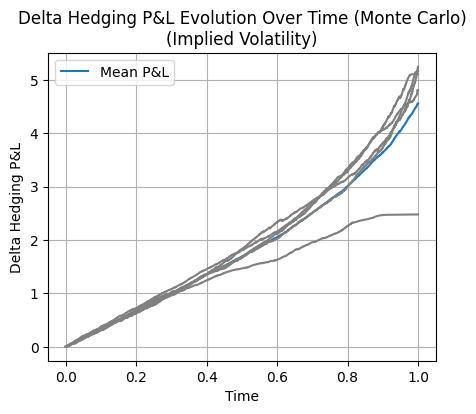

In [ ]:

# 参数设置
S0 = 100      # 初始标的价格
K = 100       # 期权执行价
r = 0.01      # 无风险利率
sigma_iv = 0.3   # 隐含波动率（用于定价和对冲）
T = 1.0       # 到期时间（年）
N = 2520       # 对冲步数（交易日）
M = 5      # 蒙特卡洛路径数

dt = T / N

def bs_delta(S, K, r, sigma, tau):
    """欧式看涨期权BS Delta，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    delta = norm.cdf(d1)
    # 到期时，S > K 为1，否则为0
    if S.ndim == 2:
        delta = np.where(tau > 0, delta, (S > K).astype(float))
    else:
        delta = np.where(tau > 0, delta, 1.0 * (S > K))
    return delta

def bs_price(S, K, r, sigma, tau):
    """欧式看涨期权BS价格，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    d2 = d1 - sigma * np.sqrt(np.maximum(tau, 0))
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    price = np.where(tau > 0, price, np.maximum(S - K, 0))
    return price

# 蒙特卡洛模拟（矩阵化）
# 1. 生成所有路径（使用realized volatility）
sigma_realized = 0.2  # 实现波动率（realized volatility），与隐含波动率不同
Z = np.random.randn(M, N)
increments = (r - 0.5 * sigma_realized ** 2) * dt + sigma_realized * np.sqrt(dt) * Z
log_S = np.cumsum(increments, axis=1)
log_S = np.concatenate([np.zeros((M,1)), log_S], axis=1)
S_paths = S0 * np.exp(log_S)  # shape (M, N+1)

# 2. 计算每个时间点的tau
taus = T - np.arange(N+1) * dt  # shape (N+1,)

# 3. 计算每个路径、每个时间点的delta（用隐含波动率）
deltas = bs_delta(S_paths, K, r, sigma_iv, taus)  # shape (M, N+1)

# 4. 初始现金流（用隐含波动率定价）
init_option_price = bs_price(S0, K, r, sigma_iv, T)
init_delta = deltas[:, 0]
cash = np.full(M, init_option_price) - init_delta * S0  # shape (M,)

# 5. 逐步对冲，记录每一步的现金头寸和P&L
cash_steps = np.zeros((M, N+1))
pnl_steps = np.zeros((M, N+1))

cash_steps[:, 0] = cash
pnl_steps[:, 0] = 0

for t in range(1, N+1):
    # delta变化量
    d_delta = deltas[:, t] - deltas[:, t-1]
    # 买入/卖出股票的现金流
    cash -= d_delta * S_paths[:, t]
    # 现金头寸复利
    cash = cash * np.exp(r * dt)
    # 当前持有股票
    shares = deltas[:, t]
    # 当前现金+股票-期权理论价值（用隐含波动率定价）
    option_value = bs_price(S_paths[:, t], K, r, sigma_iv, taus[t])
    pnl = cash + shares * S_paths[:, t] - option_value
    cash_steps[:, t] = cash
    pnl_steps[:, t] = pnl

# 画出P&L随时间变化的图
mean_pnl = np.mean(pnl_steps, axis=0)
std_pnl = np.std(pnl_steps, axis=0)
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(5,4))
plt.plot(time_grid, mean_pnl, label='Mean P&L')
plt.plot(time_grid, pnl_steps.T, color='gray', alpha=1)
plt.xlabel('Time')
plt.ylabel('Delta Hedging P&L')
plt.title('Delta Hedging P&L Evolution Over Time (Monte Carlo)\n(Implied Volatility)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\2702841044.py:22: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\2702841044.py:39: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),


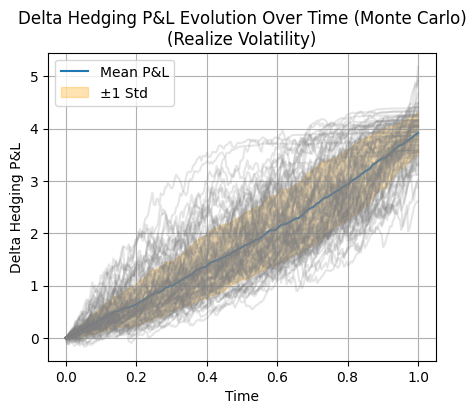

In [130]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
S0 = 100      # 初始标的价格
K = 100       # 期权执行价
r = 0.01      # 无风险利率
sigma_iv = 0.3   # 隐含波动率（用于定价和对冲）
T = 1.0       # 到期时间（年）
N = 252       # 对冲步数（交易日）
M = 100      # 蒙特卡洛路径数

dt = T / N

def bs_delta(S, K, r, sigma, tau):
    """欧式看涨期权BS Delta，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    delta = norm.cdf(d1)
    # 到期时，S > K 为1，否则为0
    if S.ndim == 2:
        delta = np.where(tau > 0, delta, (S > K).astype(float))
    else:
        delta = np.where(tau > 0, delta, 1.0 * (S > K))
    return delta

def bs_price(S, K, r, sigma, tau):
    """欧式看涨期权BS价格，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    d2 = d1 - sigma * np.sqrt(np.maximum(tau, 0))
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    price = np.where(tau > 0, price, np.maximum(S - K, 0))
    return price

# 蒙特卡洛模拟（矩阵化）
# 1. 生成所有路径（使用realized volatility）
sigma_realized = 0.2  # 实现波动率（realized volatility），与隐含波动率不同
Z = np.random.randn(M, N)
increments = (r - 0.5 * sigma_realized ** 2) * dt + sigma_realized * np.sqrt(dt) * Z
log_S = np.cumsum(increments, axis=1)
log_S = np.concatenate([np.zeros((M,1)), log_S], axis=1)
S_paths = S0 * np.exp(log_S)  # shape (M, N+1)

# 2. 计算每个时间点的tau
taus = T - np.arange(N+1) * dt  # shape (N+1,)

# 3. 计算每个路径、每个时间点的delta（用隐含波动率）
deltas = bs_delta(S_paths, K, r, sigma_realized, taus)  # shape (M, N+1)

# 4. 初始现金流（用隐含波动率定价）
init_option_price = bs_price(S0, K, r, sigma_iv, T)
init_delta = deltas[:, 0]
cash = np.full(M, init_option_price) - init_delta * S0  # shape (M,)

# 5. 逐步对冲，记录每一步的现金头寸和P&L
cash_steps = np.zeros((M, N+1))
pnl_steps = np.zeros((M, N+1))

cash_steps[:, 0] = cash
pnl_steps[:, 0] = 0

for t in range(1, N+1):
    # delta变化量
    d_delta = deltas[:, t] - deltas[:, t-1]
    # 买入/卖出股票的现金流
    cash -= d_delta * S_paths[:, t]
    # 现金头寸复利
    cash = cash * np.exp(r * dt)
    # 当前持有股票
    shares = deltas[:, t]
    # 当前现金+股票-期权理论价值（用隐含波动率定价）
    option_value = bs_price(S_paths[:, t], K, r, sigma_iv, taus[t])
    pnl = cash + shares * S_paths[:, t] - option_value
    cash_steps[:, t] = cash
    pnl_steps[:, t] = pnl

# 画出P&L随时间变化的图
mean_pnl = np.mean(pnl_steps, axis=0)
std_pnl = np.std(pnl_steps, axis=0)
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(5,4))
plt.plot(time_grid, mean_pnl, label='Mean P&L')
plt.plot(time_grid, pnl_steps.T, color='gray', alpha=0.2)
plt.fill_between(time_grid, mean_pnl-std_pnl, mean_pnl+std_pnl, color='orange', alpha=0.3, label='±1 Std')
plt.xlabel('Time')
plt.ylabel('Delta Hedging P&L')
plt.title('Delta Hedging P&L Evolution Over Time (Monte Carlo)\n(Realize Volatility)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\1113711692.py:22: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\1113711692.py:39: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),


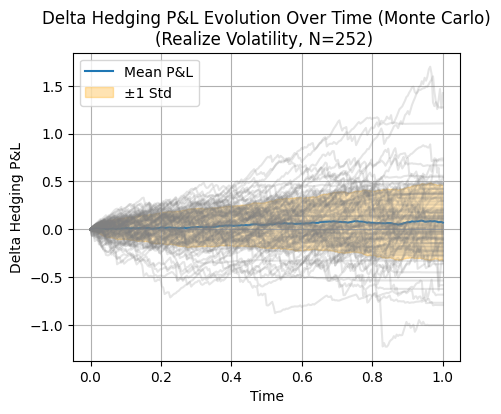

In [43]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
S0 = 100      # 初始标的价格
K = 100       # 期权执行价
r = 0.01      # 无风险利率
sigma_iv = 0.2   # 隐含波动率（用于定价和对冲）
T = 1.0       # 到期时间（年）
N = 252       # 对冲步数（交易日）
M = 100      # 蒙特卡洛路径数

dt = T / N

def bs_delta(S, K, r, sigma, tau):
    """欧式看涨期权BS Delta，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    delta = norm.cdf(d1)
    # 到期时，S > K 为1，否则为0
    if S.ndim == 2:
        delta = np.where(tau > 0, delta, (S > K).astype(float))
    else:
        delta = np.where(tau > 0, delta, 1.0 * (S > K))
    return delta

def bs_price(S, K, r, sigma, tau):
    """欧式看涨期权BS价格，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    d2 = d1 - sigma * np.sqrt(np.maximum(tau, 0))
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    price = np.where(tau > 0, price, np.maximum(S - K, 0))
    return price

# 蒙特卡洛模拟（矩阵化）
# 1. 生成所有路径（使用realized volatility）
sigma_realized = 0.2  # 实现波动率（realized volatility），与隐含波动率不同
Z = np.random.randn(M, N)
increments = (r - 0.5 * sigma_realized ** 2) * dt + sigma_realized * np.sqrt(dt) * Z
log_S = np.cumsum(increments, axis=1)
log_S = np.concatenate([np.zeros((M,1)), log_S], axis=1)
S_paths = S0 * np.exp(log_S)  # shape (M, N+1)

# 2. 计算每个时间点的tau
taus = T - np.arange(N+1) * dt  # shape (N+1,)

# 3. 计算每个路径、每个时间点的delta（用隐含波动率）
deltas = bs_delta(S_paths, K, r, sigma_realized, taus)  # shape (M, N+1)

# 4. 初始现金流（用隐含波动率定价）
init_option_price = bs_price(S0, K, r, sigma_iv, T)
init_delta = deltas[:, 0]
cash = np.full(M, init_option_price) - init_delta * S0  # shape (M,)

# 5. 逐步对冲，记录每一步的现金头寸和P&L
cash_steps = np.zeros((M, N+1))
pnl_steps = np.zeros((M, N+1))

cash_steps[:, 0] = cash
pnl_steps[:, 0] = 0

for t in range(1, N+1):
    # delta变化量
    d_delta = deltas[:, t] - deltas[:, t-1]
    # 买入/卖出股票的现金流
    cash -= d_delta * S_paths[:, t]
    # 现金头寸复利
    cash = cash * np.exp(r * dt)
    # 当前持有股票
    shares = deltas[:, t]
    # 当前现金+股票-期权理论价值（用隐含波动率定价）
    option_value = bs_price(S_paths[:, t], K, r, sigma_iv, taus[t])
    pnl = cash + shares * S_paths[:, t] - option_value
    cash_steps[:, t] = cash
    pnl_steps[:, t] = pnl

# 画出P&L随时间变化的图
mean_pnl = np.mean(pnl_steps, axis=0)
std_pnl = np.std(pnl_steps, axis=0)
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(5,4))
plt.plot(time_grid, mean_pnl, label='Mean P&L')
plt.plot(time_grid, pnl_steps.T, color='gray', alpha=0.2)
plt.fill_between(time_grid, mean_pnl-std_pnl, mean_pnl+std_pnl, color='orange', alpha=0.3, label='±1 Std')
plt.xlabel('Time')
plt.ylabel('Delta Hedging P&L')
plt.title('Delta Hedging P&L Evolution Over Time (Monte Carlo)\n(Realize Volatility, N=252) ')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\2823843577.py:22: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\2823843577.py:39: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),


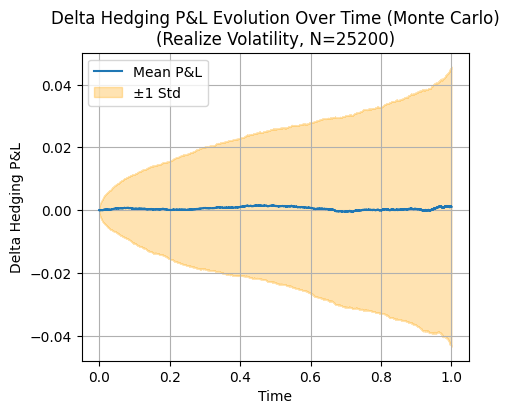

: 

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
S0 = 100      # 初始标的价格
K = 100       # 期权执行价
r = 0.01      # 无风险利率
sigma_iv = 0.2   # 隐含波动率（用于定价和对冲）
T = 1.0       # 到期时间（年）
N = 25200       # 对冲步数（交易日）
M = 1000      # 蒙特卡洛路径数

dt = T / N

def bs_delta(S, K, r, sigma, tau):
    """欧式看涨期权BS Delta，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    delta = norm.cdf(d1)
    # 到期时，S > K 为1，否则为0
    if S.ndim == 2:
        delta = np.where(tau > 0, delta, (S > K).astype(float))
    else:
        delta = np.where(tau > 0, delta, 1.0 * (S > K))
    return delta

def bs_price(S, K, r, sigma, tau):
    """欧式看涨期权BS价格，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    d2 = d1 - sigma * np.sqrt(np.maximum(tau, 0))
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    price = np.where(tau > 0, price, np.maximum(S - K, 0))
    return price

# 蒙特卡洛模拟（矩阵化）
# 1. 生成所有路径（使用realized volatility）
sigma_realized = 0.2  # 实现波动率（realized volatility），与隐含波动率不同
Z = np.random.randn(M, N)
increments = (r - 0.5 * sigma_realized ** 2) * dt + sigma_realized * np.sqrt(dt) * Z
log_S = np.cumsum(increments, axis=1)
log_S = np.concatenate([np.zeros((M,1)), log_S], axis=1)
S_paths = S0 * np.exp(log_S)  # shape (M, N+1)

# 2. 计算每个时间点的tau
taus = T - np.arange(N+1) * dt  # shape (N+1,)

# 3. 计算每个路径、每个时间点的delta（用隐含波动率）
deltas = bs_delta(S_paths, K, r, sigma_realized, taus)  # shape (M, N+1)

# 4. 初始现金流（用隐含波动率定价）
init_option_price = bs_price(S0, K, r, sigma_iv, T)
init_delta = deltas[:, 0]
cash = np.full(M, init_option_price) - init_delta * S0  # shape (M,)

# 5. 逐步对冲，记录每一步的现金头寸和P&L
cash_steps = np.zeros((M, N+1))
pnl_steps = np.zeros((M, N+1))

cash_steps[:, 0] = cash
pnl_steps[:, 0] = 0

for t in range(1, N+1):
    # delta变化量
    d_delta = deltas[:, t] - deltas[:, t-1]
    # 买入/卖出股票的现金流
    cash -= d_delta * S_paths[:, t]
    # 现金头寸复利
    cash = cash * np.exp(r * dt)
    # 当前持有股票
    shares = deltas[:, t]
    # 当前现金+股票-期权理论价值（用隐含波动率定价）
    option_value = bs_price(S_paths[:, t], K, r, sigma_iv, taus[t])
    pnl = cash + shares * S_paths[:, t] - option_value
    cash_steps[:, t] = cash
    pnl_steps[:, t] = pnl

# 画出P&L随时间变化的图
mean_pnl = np.mean(pnl_steps, axis=0)
std_pnl = np.std(pnl_steps, axis=0)
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(5,4))
plt.plot(time_grid, mean_pnl, label='Mean P&L')
#plt.plot(time_grid, pnl_steps.T, color='gray', alpha=0.2)
plt.fill_between(time_grid, mean_pnl-std_pnl, mean_pnl+std_pnl, color='orange', alpha=0.3, label='±1 Std')
plt.xlabel('Time')
plt.ylabel('Delta Hedging P&L')
plt.title('Delta Hedging P&L Evolution Over Time (Monte Carlo)\n(Realize Volatility, N=25200)')
plt.legend()
plt.grid(True)
plt.show()


In [131]:
np.std(pnl_steps[:,-1])

0.41826101299891383

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\471331986.py:22: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\471331986.py:39: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),


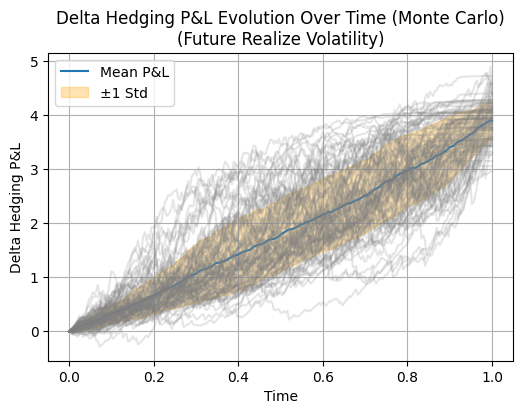

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
S0 = 100      # 初始标的价格
K = 100       # 期权执行价
r = 0.01      # 无风险利率
sigma_iv = 0.3   # 隐含波动率（用于定价和对冲）
T = 1.0       # 到期时间（年）
N = 252       # 对冲步数（交易日）
M = 100      # 蒙特卡洛路径数

dt = T / N

def bs_delta(S, K, r, sigma, tau):
    """欧式看涨期权BS Delta，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    delta = norm.cdf(d1)
    # 到期时，S > K 为1，否则为0
    if S.ndim == 2:
        delta = np.where(tau > 0, delta, (S > K).astype(float))
    else:
        delta = np.where(tau > 0, delta, 1.0 * (S > K))
    return delta

def bs_price(S, K, r, sigma, tau):
    """欧式看涨期权BS价格，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    d2 = d1 - sigma * np.sqrt(np.maximum(tau, 0))
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    price = np.where(tau > 0, price, np.maximum(S - K, 0))
    return price

# 蒙特卡洛模拟（矩阵化）
# 1. 生成所有路径（使用realized volatility）
sigma_realized = 0.2  # 实现波动率（realized volatility），与隐含波动率不同
Z = np.random.randn(M, N)
increments = (r - 0.5 * sigma_realized ** 2) * dt + sigma_realized * np.sqrt(dt) * Z
log_S = np.cumsum(increments, axis=1)
log_S = np.concatenate([np.zeros((M,1)), log_S], axis=1)
S_paths = S0 * np.exp(log_S)  # shape (M, N+1)

# 2. 计算每个时间点的tau
taus = T - np.arange(N+1) * dt  # shape (N+1,)

# 3. 计算每个路径、每个时间点的delta（用n到n+1的单个收益率平方计算波动率）
# 先计算每条路径每个区间的realized volatility（单个收益率平方）
# realized sigma for each interval: shape (M, N)
# 计算每个时刻n对应的未来n到N的已实现波动率
log_S = np.log(S_paths)
M, N_plus_1 = log_S.shape  # N+1
N = N_plus_1 - 1

# 计算每条路径从n到N的累计对数收益平方和
future_sq = np.zeros((M, N_plus_1))
for n in range(N_plus_1):
    # 从n到N的所有对数收益
    if n < N:
        returns = log_S[:, n+1:] - log_S[:, n:-1]
        sum_sq = np.sum(returns**2, axis=1)
        T_future = (N - n) * dt
        # 避免除以0
        realized_sigma = np.sqrt(sum_sq / T_future)
        future_sq[:, n] = realized_sigma
    else:
        # 到期时已实现波动率设为最后一个区间的波动率
        realized_sigma = np.sqrt((log_S[:, -1] - log_S[:, -2])**2 / dt)
        future_sq[:, n] = realized_sigma

realized_sigmas = future_sq  # shape (M, N+1)
deltas = bs_delta(S_paths, K, r, realized_sigmas, taus)  # shape (M, N+1)

# 4. 初始现金流（用隐含波动率定价）
init_option_price = bs_price(S0, K, r, sigma_iv, T)
init_delta = deltas[:, 0]
cash = np.full(M, init_option_price) - init_delta * S0  # shape (M,)

# 5. 逐步对冲，记录每一步的现金头寸和P&L
cash_steps = np.zeros((M, N+1))
pnl_steps = np.zeros((M, N+1))

cash_steps[:, 0] = cash
pnl_steps[:, 0] = 0

for t in range(1, N+1):
    # delta变化量
    d_delta = deltas[:, t] - deltas[:, t-1]
    # 买入/卖出股票的现金流
    cash -= d_delta * S_paths[:, t]
    # 现金头寸复利
    cash = cash * np.exp(r * dt)
    # 当前持有股票
    shares = deltas[:, t]
    # 当前现金+股票-期权理论价值（用隐含波动率定价）
    option_value = bs_price(S_paths[:, t], K, r, sigma_iv, taus[t])
    pnl = cash + shares * S_paths[:, t] - option_value
    cash_steps[:, t] = cash
    pnl_steps[:, t] = pnl

# 画出P&L随时间变化的图
mean_pnl = np.mean(pnl_steps, axis=0)
std_pnl = np.std(pnl_steps, axis=0)
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(6,4))
plt.plot(time_grid, mean_pnl, label='Mean P&L')
plt.plot(time_grid, pnl_steps.T, color='gray', alpha=0.2)
plt.fill_between(time_grid, mean_pnl-std_pnl, mean_pnl+std_pnl, color='orange', alpha=0.3, label='±1 Std')
plt.xlabel('Time')
plt.ylabel('Delta Hedging P&L')
plt.title('Delta Hedging P&L Evolution Over Time (Monte Carlo)\n(Future Realize Volatility)')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
np.std(pnl_steps[:,-1])

0.3452394252126616

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\1701719683.py:22: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\1701719683.py:39: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),


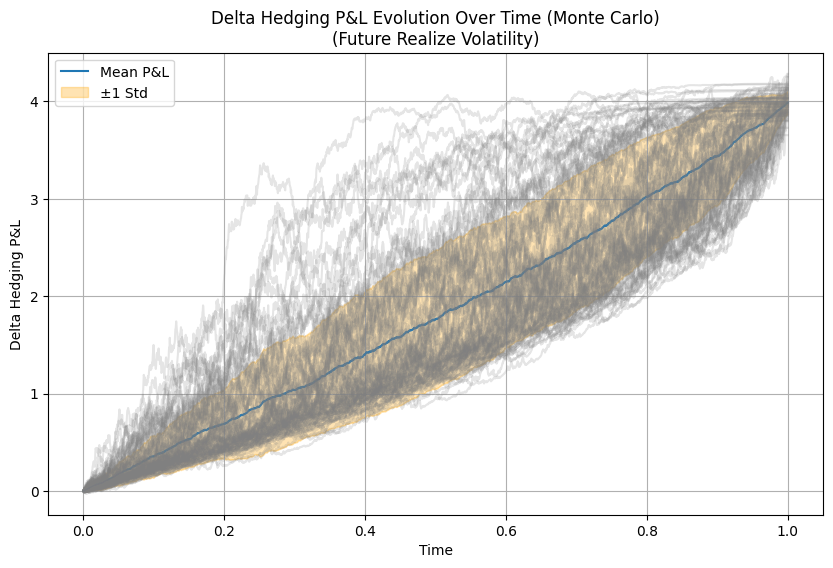

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
S0 = 100      # 初始标的价格
K = 100       # 期权执行价
r = 0.01      # 无风险利率
sigma_iv = 0.3   # 隐含波动率（用于定价和对冲）
T = 1.0       # 到期时间（年）
N = 2520       # 对冲步数（交易日）
M = 100      # 蒙特卡洛路径数

dt = T / N

def bs_delta(S, K, r, sigma, tau):
    """欧式看涨期权BS Delta，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    delta = norm.cdf(d1)
    # 到期时，S > K 为1，否则为0
    if S.ndim == 2:
        delta = np.where(tau > 0, delta, (S > K).astype(float))
    else:
        delta = np.where(tau > 0, delta, 1.0 * (S > K))
    return delta

def bs_price(S, K, r, sigma, tau):
    """欧式看涨期权BS价格，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    d2 = d1 - sigma * np.sqrt(np.maximum(tau, 0))
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    price = np.where(tau > 0, price, np.maximum(S - K, 0))
    return price

# 蒙特卡洛模拟（矩阵化）
# 1. 生成所有路径（使用realized volatility）
sigma_realized = 0.2  # 实现波动率（realized volatility），与隐含波动率不同
Z = np.random.randn(M, N)
increments = (r - 0.5 * sigma_realized ** 2) * dt + sigma_realized * np.sqrt(dt) * Z
log_S = np.cumsum(increments, axis=1)
log_S = np.concatenate([np.zeros((M,1)), log_S], axis=1)
S_paths = S0 * np.exp(log_S)  # shape (M, N+1)

# 2. 计算每个时间点的tau
taus = T - np.arange(N+1) * dt  # shape (N+1,)

# 3. 计算每个路径、每个时间点的delta（用n到n+1的单个收益率平方计算波动率）
# 先计算每条路径每个区间的realized volatility（单个收益率平方）
# realized sigma for each interval: shape (M, N)
# 计算每个时刻n对应的未来n到N的已实现波动率
log_S = np.log(S_paths)
M, N_plus_1 = log_S.shape  # N+1
N = N_plus_1 - 1

# 计算每条路径从n到N的累计对数收益平方和
future_sq = np.zeros((M, N_plus_1))
for n in range(N_plus_1):
    # 从n到N的所有对数收益
    if n < N:
        returns = log_S[:, n+1:] - log_S[:, n:-1]
        sum_sq = np.sum(returns**2, axis=1)
        T_future = (N - n) * dt
        # 避免除以0
        realized_sigma = np.sqrt(sum_sq / T_future)
        future_sq[:, n] = realized_sigma
    else:
        # 到期时已实现波动率设为最后一个区间的波动率
        realized_sigma = np.sqrt((log_S[:, -1] - log_S[:, -2])**2 / dt)
        future_sq[:, n] = realized_sigma

realized_sigmas = future_sq  # shape (M, N+1)
deltas = bs_delta(S_paths, K, r, realized_sigmas, taus)  # shape (M, N+1)

# 4. 初始现金流（用隐含波动率定价）
init_option_price = bs_price(S0, K, r, sigma_iv, T)
init_delta = deltas[:, 0]
cash = np.full(M, init_option_price) - init_delta * S0  # shape (M,)

# 5. 逐步对冲，记录每一步的现金头寸和P&L
cash_steps = np.zeros((M, N+1))
pnl_steps = np.zeros((M, N+1))

cash_steps[:, 0] = cash
pnl_steps[:, 0] = 0

for t in range(1, N+1):
    # delta变化量
    d_delta = deltas[:, t] - deltas[:, t-1]
    # 买入/卖出股票的现金流
    cash -= d_delta * S_paths[:, t]
    # 现金头寸复利
    cash = cash * np.exp(r * dt)
    # 当前持有股票
    shares = deltas[:, t]
    # 当前现金+股票-期权理论价值（用隐含波动率定价）
    option_value = bs_price(S_paths[:, t], K, r, sigma_iv, taus[t])
    pnl = cash + shares * S_paths[:, t] - option_value
    cash_steps[:, t] = cash
    pnl_steps[:, t] = pnl

# 画出P&L随时间变化的图
mean_pnl = np.mean(pnl_steps, axis=0)
std_pnl = np.std(pnl_steps, axis=0)
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(10,6))
plt.plot(time_grid, mean_pnl, label='Mean P&L')
plt.plot(time_grid, pnl_steps.T, color='gray', alpha=0.2)
plt.fill_between(time_grid, mean_pnl-std_pnl, mean_pnl+std_pnl, color='orange', alpha=0.3, label='±1 Std')
plt.xlabel('Time')
plt.ylabel('Delta Hedging P&L')
plt.title('Delta Hedging P&L Evolution Over Time (Monte Carlo)\n(Future Realize Volatility)')
plt.legend()
plt.grid(True)
plt.show()

In [136]:
np.std(pnl_steps[:,-1])*np.sqrt(10)

0.3823441666725046

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\361592689.py:22: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\361592689.py:39: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),


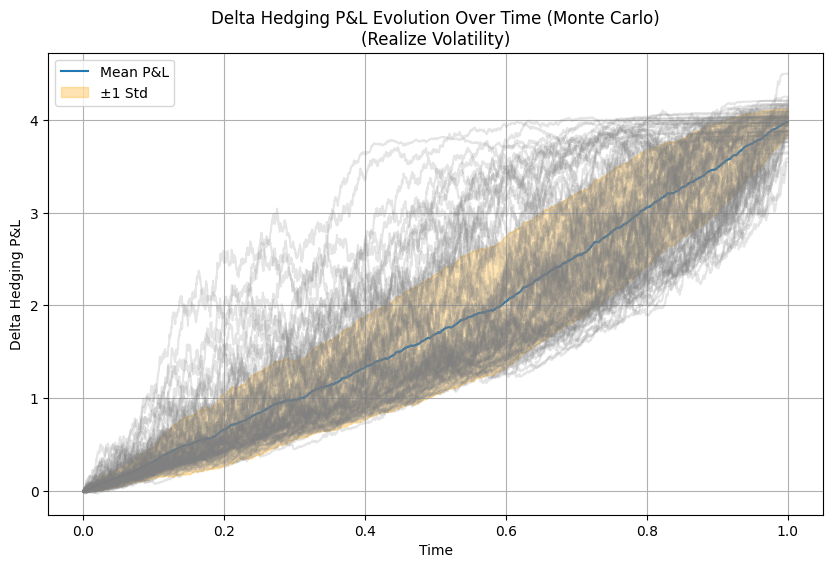

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
S0 = 100      # 初始标的价格
K = 100       # 期权执行价
r = 0.01      # 无风险利率
sigma_iv = 0.3   # 隐含波动率（用于定价和对冲）
T = 1.0       # 到期时间（年）
N = 2520       # 对冲步数（交易日）
M = 100      # 蒙特卡洛路径数

dt = T / N

def bs_delta(S, K, r, sigma, tau):
    """欧式看涨期权BS Delta，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    delta = norm.cdf(d1)
    # 到期时，S > K 为1，否则为0
    if S.ndim == 2:
        delta = np.where(tau > 0, delta, (S > K).astype(float))
    else:
        delta = np.where(tau > 0, delta, 1.0 * (S > K))
    return delta

def bs_price(S, K, r, sigma, tau):
    """欧式看涨期权BS价格，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    d2 = d1 - sigma * np.sqrt(np.maximum(tau, 0))
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    price = np.where(tau > 0, price, np.maximum(S - K, 0))
    return price

# 蒙特卡洛模拟（矩阵化）
# 1. 生成所有路径（使用realized volatility）
sigma_realized = 0.2  # 实现波动率（realized volatility），与隐含波动率不同
Z = np.random.randn(M, N)
increments = (r - 0.5 * sigma_realized ** 2) * dt + sigma_realized * np.sqrt(dt) * Z
log_S = np.cumsum(increments, axis=1)
log_S = np.concatenate([np.zeros((M,1)), log_S], axis=1)
S_paths = S0 * np.exp(log_S)  # shape (M, N+1)

# 2. 计算每个时间点的tau
taus = T - np.arange(N+1) * dt  # shape (N+1,)

# 3. 计算每个路径、每个时间点的delta（用隐含波动率）
deltas = bs_delta(S_paths, K, r, sigma_realized, taus)  # shape (M, N+1)

# 4. 初始现金流（用隐含波动率定价）
init_option_price = bs_price(S0, K, r, sigma_iv, T)
init_delta = deltas[:, 0]
cash = np.full(M, init_option_price) - init_delta * S0  # shape (M,)

# 5. 逐步对冲，记录每一步的现金头寸和P&L
cash_steps = np.zeros((M, N+1))
pnl_steps = np.zeros((M, N+1))

cash_steps[:, 0] = cash
pnl_steps[:, 0] = 0

for t in range(1, N+1):
    # delta变化量
    d_delta = deltas[:, t] - deltas[:, t-1]
    # 买入/卖出股票的现金流
    cash -= d_delta * S_paths[:, t]
    # 现金头寸复利
    cash = cash * np.exp(r * dt)
    # 当前持有股票
    shares = deltas[:, t]
    # 当前现金+股票-期权理论价值（用隐含波动率定价）
    option_value = bs_price(S_paths[:, t], K, r, sigma_iv, taus[t])
    pnl = cash + shares * S_paths[:, t] - option_value
    cash_steps[:, t] = cash
    pnl_steps[:, t] = pnl

# 画出P&L随时间变化的图
mean_pnl = np.mean(pnl_steps, axis=0)
std_pnl = np.std(pnl_steps, axis=0)
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(10,6))
plt.plot(time_grid, mean_pnl, label='Mean P&L')
plt.plot(time_grid, pnl_steps.T, color='gray', alpha=0.2)
plt.fill_between(time_grid, mean_pnl-std_pnl, mean_pnl+std_pnl, color='orange', alpha=0.3, label='±1 Std')
plt.xlabel('Time')
plt.ylabel('Delta Hedging P&L')
plt.title('Delta Hedging P&L Evolution Over Time (Monte Carlo)\n(Realize Volatility)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\2739173501.py:22: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\2739173501.py:39: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),


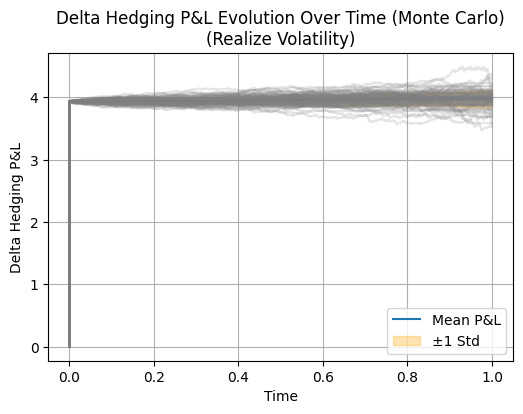

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
S0 = 100      # 初始标的价格
K = 100       # 期权执行价
r = 0.01      # 无风险利率
sigma_iv = 0.3   # 隐含波动率（用于定价和对冲）
T = 1.0       # 到期时间（年）
N = 2520       # 对冲步数（交易日）
M = 100      # 蒙特卡洛路径数

dt = T / N

def bs_delta(S, K, r, sigma, tau):
    """欧式看涨期权BS Delta，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    delta = norm.cdf(d1)
    # 到期时，S > K 为1，否则为0
    if S.ndim == 2:
        delta = np.where(tau > 0, delta, (S > K).astype(float))
    else:
        delta = np.where(tau > 0, delta, 1.0 * (S > K))
    return delta

def bs_price(S, K, r, sigma, tau):
    """欧式看涨期权BS价格，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    d2 = d1 - sigma * np.sqrt(np.maximum(tau, 0))
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    price = np.where(tau > 0, price, np.maximum(S - K, 0))
    return price


def bs_gamma(S, K, r, sigma, tau):
    """欧式看涨期权BS Gamma，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    gamma = np.where(
        tau > 0,
        norm.pdf(d1) / (S * sigma * np.sqrt(tau)),
        0.0
    )
    return gamma

# 蒙特卡洛模拟（矩阵化）
# 1. 生成所有路径（使用realized volatility）
sigma_realized = 0.2  # 实现波动率（realized volatility），与隐含波动率不同
Z = np.random.randn(M, N)
increments = (r - 0.5 * sigma_realized ** 2) * dt + sigma_realized * np.sqrt(dt) * Z
log_S = np.cumsum(increments, axis=1)
log_S = np.concatenate([np.zeros((M,1)), log_S], axis=1)
S_paths = S0 * np.exp(log_S)  # shape (M, N+1)

# 2. 计算每个时间点的tau
taus = T - np.arange(N+1) * dt  # shape (N+1,)

# 3. 计算每个路径、每个时间点的delta（用隐含波动率）
deltas = bs_delta(S_paths, K, r, sigma_realized, taus)  # shape (M, N+1)

# 4. 初始现金流（用隐含波动率定价）
init_option_price = bs_price(S0, K, r, sigma_iv, T)
init_delta = deltas[:, 0]
cash = np.full(M, init_option_price) - init_delta * S0  # shape (M,)

# 5. 逐步对冲，记录每一步的现金头寸和P&L
cash_steps = np.zeros((M, N+1))
pnl_steps = np.zeros((M, N+1))

cash_steps[:, 0] = cash
pnl_steps[:, 0] = 0

for t in range(1, N+1):
    # delta变化量
    d_delta = deltas[:, t] - deltas[:, t-1]
    # 买入/卖出股票的现金流
    cash -= d_delta * S_paths[:, t]
    # 现金头寸复利
    cash = cash * np.exp(r * dt)
    # 当前持有股票
    shares = deltas[:, t]
    # 当前现金+股票-期权理论价值（用隐含波动率定价）
    option_value = bs_price(S_paths[:, t], K, r, sigma_realized, taus[t])
    pnl = cash + shares * S_paths[:, t] - option_value
    cash_steps[:, t] = cash
    pnl_steps[:, t] = pnl

# 画出P&L随时间变化的图
mean_pnl = np.mean(pnl_steps, axis=0)
std_pnl = np.std(pnl_steps, axis=0)
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(6,4))
plt.plot(time_grid, mean_pnl, label='Mean P&L')
plt.plot(time_grid, pnl_steps.T, color='gray', alpha=0.2)
plt.fill_between(time_grid, mean_pnl-std_pnl, mean_pnl+std_pnl, color='orange', alpha=0.3, label='±1 Std')
plt.xlabel('Time')
plt.ylabel('Delta Hedging P&L')
plt.title('Delta Hedging P&L Evolution Over Time (Monte Carlo)\n(Realize Volatility)')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
0.14*np.sqrt(10)

0.44271887242357316

Text(0.5, 1.0, 'Delta Hedging P&L Std Over Time (N=2520))')

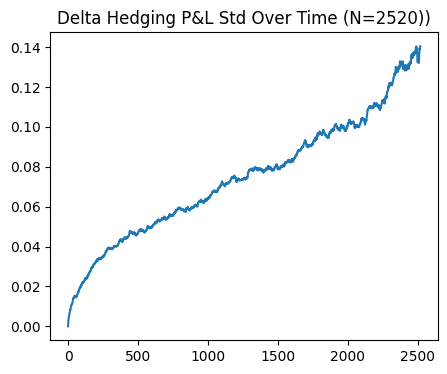

In [17]:
plt.figure(figsize=(5, 4))
plt.plot(pnl_steps.std(axis=0))
plt.title(f"Delta Hedging P&L Std Over Time (N=2520))")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\2739173501.py:54: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\2739173501.py:59: RuntimeWarning: divide by zero encountered in divide
  norm.pdf(d1) / (S * sigma * np.sqrt(tau)),


Text(0.5, 1.0, 'Error Process sqrt(Var) Over Time (N=2520))')

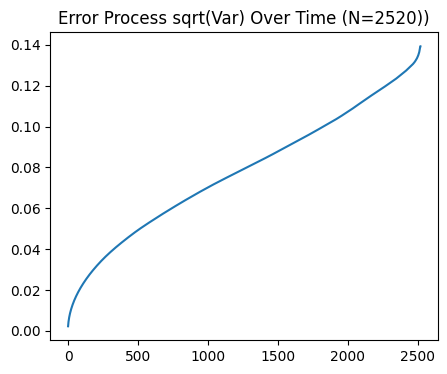

In [19]:
gamma_path = bs_gamma(S_paths, K, r, sigma_realized, taus)  # shape (M, N+1)

Error_path = (1/2)*(sigma_realized**4)*(gamma_path**2)*(S_paths**4)*(dt**2)
Error_path = Error_path.cumsum(axis=1)
# Error_path.mean(axis=0).cumsum()
plt.figure(figsize=(5, 4))
plt.plot(np.sqrt(Error_path.mean(axis=0)))
plt.title(f"Error Process sqrt(Var) Over Time (N=2520))")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\210807107.py:22: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\210807107.py:39: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),


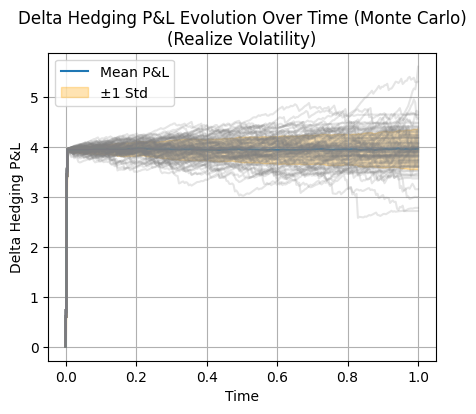

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
S0 = 100      # 初始标的价格
K = 100       # 期权执行价
r = 0.01      # 无风险利率
sigma_iv = 0.3   # 隐含波动率（用于定价和对冲）
T = 1.0       # 到期时间（年）
N = 252       # 对冲步数（交易日）
M = 100      # 蒙特卡洛路径数

dt = T / N

def bs_delta(S, K, r, sigma, tau):
    """欧式看涨期权BS Delta，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    delta = norm.cdf(d1)
    # 到期时，S > K 为1，否则为0
    if S.ndim == 2:
        delta = np.where(tau > 0, delta, (S > K).astype(float))
    else:
        delta = np.where(tau > 0, delta, 1.0 * (S > K))
    return delta

def bs_price(S, K, r, sigma, tau):
    """欧式看涨期权BS价格，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    d2 = d1 - sigma * np.sqrt(np.maximum(tau, 0))
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    price = np.where(tau > 0, price, np.maximum(S - K, 0))
    return price


def bs_gamma(S, K, r, sigma, tau):
    """欧式看涨期权BS Gamma，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    gamma = np.where(
        tau > 0,
        norm.pdf(d1) / (S * sigma * np.sqrt(tau)),
        0.0
    )
    return gamma

# 蒙特卡洛模拟（矩阵化）
# 1. 生成所有路径（使用realized volatility）
sigma_realized = 0.2  # 实现波动率（realized volatility），与隐含波动率不同
Z = np.random.randn(M, N)
increments = (r - 0.5 * sigma_realized ** 2) * dt + sigma_realized * np.sqrt(dt) * Z
log_S = np.cumsum(increments, axis=1)
log_S = np.concatenate([np.zeros((M,1)), log_S], axis=1)
S_paths = S0 * np.exp(log_S)  # shape (M, N+1)

# 2. 计算每个时间点的tau
taus = T - np.arange(N+1) * dt  # shape (N+1,)

# 3. 计算每个路径、每个时间点的delta（用隐含波动率）
deltas = bs_delta(S_paths, K, r, sigma_realized, taus)  # shape (M, N+1)

# 4. 初始现金流（用隐含波动率定价）
init_option_price = bs_price(S0, K, r, sigma_iv, T)
init_delta = deltas[:, 0]
cash = np.full(M, init_option_price) - init_delta * S0  # shape (M,)

# 5. 逐步对冲，记录每一步的现金头寸和P&L
cash_steps = np.zeros((M, N+1))
pnl_steps = np.zeros((M, N+1))

cash_steps[:, 0] = cash
pnl_steps[:, 0] = 0

for t in range(1, N+1):
    # delta变化量
    d_delta = deltas[:, t] - deltas[:, t-1]
    # 买入/卖出股票的现金流
    cash -= d_delta * S_paths[:, t]
    # 现金头寸复利
    cash = cash * np.exp(r * dt)
    # 当前持有股票
    shares = deltas[:, t]
    # 当前现金+股票-期权理论价值（用隐含波动率定价）
    option_value = bs_price(S_paths[:, t], K, r, sigma_realized, taus[t])
    pnl = cash + shares * S_paths[:, t] - option_value
    cash_steps[:, t] = cash
    pnl_steps[:, t] = pnl

# 画出P&L随时间变化的图
mean_pnl = np.mean(pnl_steps, axis=0)
std_pnl = np.std(pnl_steps, axis=0)
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(5,4))
plt.plot(time_grid, mean_pnl, label='Mean P&L')
plt.plot(time_grid, pnl_steps.T, color='gray', alpha=0.2)
plt.fill_between(time_grid, mean_pnl-std_pnl, mean_pnl+std_pnl, color='orange', alpha=0.3, label='±1 Std')
plt.xlabel('Time')
plt.ylabel('Delta Hedging P&L')
plt.title('Delta Hedging P&L Evolution Over Time (Monte Carlo)\n(Realize Volatility)')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Delta Hedging P&L Std Over Time (N=252))')

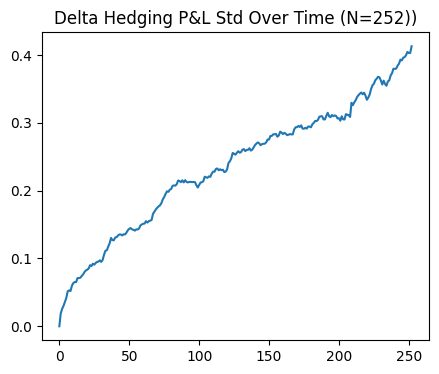

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(pnl_steps.std(axis=0))
plt.title(f"Delta Hedging P&L Std Over Time (N=252))")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\210807107.py:54: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\210807107.py:59: RuntimeWarning: divide by zero encountered in divide
  norm.pdf(d1) / (S * sigma * np.sqrt(tau)),


Text(0.5, 1.0, 'Error Process Std Over Time (N=252))')

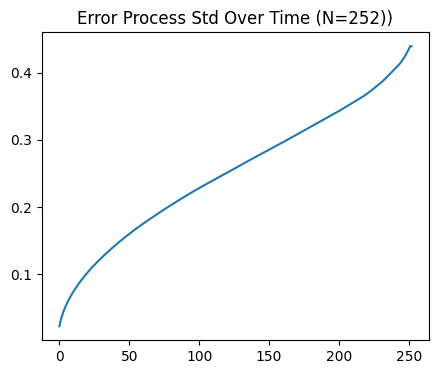

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(pnl_steps.std(axis=0))
plt.title(f"Delta Hedging P&L Std Over Time (N=252))")
    
gamma_path = bs_gamma(S_paths, K, r, sigma_realized, taus)  # shape (M, N+1)

Error_path = (1/2)*(sigma_realized**4)*(gamma_path**2)*(S_paths**4)*(dt**2)
Error_path = Error_path.cumsum(axis=1)
# Error_path.mean(axis=0).cumsum()
plt.figure(figsize=(5, 4))
plt.plot(np.sqrt(Error_path.mean(axis=0)))
plt.title(f"Error Process sqrt(Var) Over Time (N=252))")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\713514137.py:22: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\713514137.py:39: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),


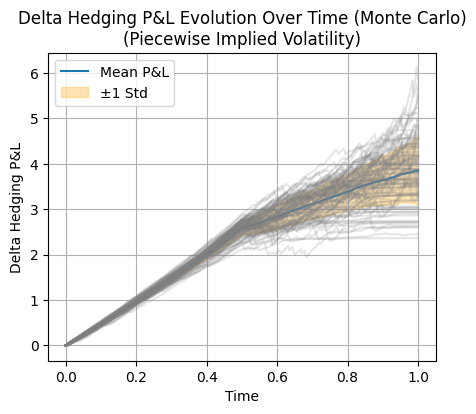

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
S0 = 100      # 初始标的价格
K = 100       # 期权执行价
r = 0.01      # 无风险利率
sigma_iv = 0.3   # 隐含波动率（用于定价和对冲）
T = 1.0       # 到期时间（年）
N = 252      # 对冲步数（交易日）
M = 100      # 蒙特卡洛路径数

dt = T / N

def bs_delta(S, K, r, sigma, tau):
    """欧式看涨期权BS Delta，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    delta = norm.cdf(d1)
    # 到期时，S > K 为1，否则为0
    if S.ndim == 2:
        delta = np.where(tau > 0, delta, (S > K).astype(float))
    else:
        delta = np.where(tau > 0, delta, 1.0 * (S > K))
    return delta

def bs_price(S, K, r, sigma, tau):
    """欧式看涨期权BS价格，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    d2 = d1 - sigma * np.sqrt(np.maximum(tau, 0))
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    price = np.where(tau > 0, price, np.maximum(S - K, 0))
    return price

# 蒙特卡洛模拟（矩阵化）
# 1. 生成所有路径（使用分段realized volatility）
# 前半年（126步）sigma1 = sqrt(0.02)，后半年（126步）sigma2 = sqrt(0.06)
sigma1 = np.sqrt(0.02)
sigma2 = np.sqrt(0.06)
sigma_realized_steps = np.concatenate([np.full(N//2, sigma1), np.full(N - N//2, sigma2)])  # shape (N,)

Z = np.random.randn(M, N)
increments = (r - 0.5 * sigma_realized_steps**2) * dt + sigma_realized_steps * np.sqrt(dt) * Z
log_S = np.cumsum(increments, axis=1)
log_S = np.concatenate([np.zeros((M,1)), log_S], axis=1)
S_paths = S0 * np.exp(log_S)  # shape (M, N+1)

# 2. 计算每个时间点的tau
taus = T - np.arange(N+1) * dt  # shape (N+1,)

# 3. 计算每个路径、每个时间点的delta（用realized volatility，分段）
# 这里每个时间点的sigma_realized不同，需构造shape为(N+1,)的sigma_realized_time
sigma_realized_time = np.concatenate([np.full(N//2+1, sigma1), np.full(N - N//2, sigma2)])  # shape (N+1,)
# 由于N为偶数，N//2+1+N-N//2 = N+1

deltas = bs_delta(S_paths, K, r, sigma_iv, taus)  # shape (M, N+1)

# 4. 初始现金流（用隐含波动率定价）
init_option_price = bs_price(S0, K, r, sigma_iv, T)
init_delta = deltas[:, 0]
cash = np.full(M, init_option_price) - init_delta * S0  # shape (M,)

# 5. 逐步对冲，记录每一步的现金头寸和P&L
cash_steps = np.zeros((M, N+1))
pnl_steps = np.zeros((M, N+1))

cash_steps[:, 0] = cash
pnl_steps[:, 0] = 0

for t in range(1, N+1):
    # delta变化量
    d_delta = deltas[:, t] - deltas[:, t-1]
    # 买入/卖出股票的现金流
    cash -= d_delta * S_paths[:, t]
    # 现金头寸复利
    cash = cash * np.exp(r * dt)
    # 当前持有股票
    shares = deltas[:, t]
    # 当前现金+股票-期权理论价值（用隐含波动率定价）
    option_value = bs_price(S_paths[:, t], K, r, sigma_iv, taus[t])
    pnl = cash + shares * S_paths[:, t] - option_value
    cash_steps[:, t] = cash
    pnl_steps[:, t] = pnl

# 画出P&L随时间变化的图
mean_pnl = np.mean(pnl_steps, axis=0)
std_pnl = np.std(pnl_steps, axis=0)
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(5,4))
plt.plot(time_grid, mean_pnl, label='Mean P&L')
plt.plot(time_grid, pnl_steps.T, color='gray', alpha=0.2)
plt.fill_between(time_grid, mean_pnl-std_pnl, mean_pnl+std_pnl, color='orange', alpha=0.3, label='±1 Std')
plt.xlabel('Time')
plt.ylabel('Delta Hedging P&L')
plt.title('Delta Hedging P&L Evolution Over Time (Monte Carlo)\n(Piecewise Implied Volatility)')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\3573168864.py:22: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\3573168864.py:39: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),


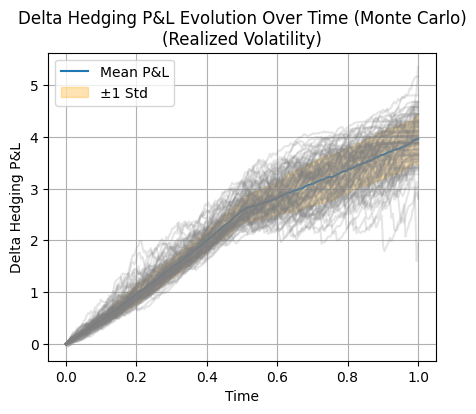

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
S0 = 100      # 初始标的价格
K = 100       # 期权执行价
r = 0.01      # 无风险利率
sigma_iv = 0.3   # 隐含波动率（用于定价和对冲）
T = 1.0       # 到期时间（年）
N = 252      # 对冲步数（交易日）
M = 100      # 蒙特卡洛路径数

dt = T / N

def bs_delta(S, K, r, sigma, tau):
    """欧式看涨期权BS Delta，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    delta = norm.cdf(d1)
    # 到期时，S > K 为1，否则为0
    if S.ndim == 2:
        delta = np.where(tau > 0, delta, (S > K).astype(float))
    else:
        delta = np.where(tau > 0, delta, 1.0 * (S > K))
    return delta

def bs_price(S, K, r, sigma, tau):
    """欧式看涨期权BS价格，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    d2 = d1 - sigma * np.sqrt(np.maximum(tau, 0))
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    price = np.where(tau > 0, price, np.maximum(S - K, 0))
    return price

# 蒙特卡洛模拟（矩阵化）
# 1. 生成所有路径（使用分段realized volatility）
# 前半年（126步）sigma1 = sqrt(0.02)，后半年（126步）sigma2 = sqrt(0.06)
sigma1 = np.sqrt(0.02)
sigma2 = np.sqrt(0.06)
sigma_realized_steps = np.concatenate([np.full(N//2, sigma1), np.full(N - N//2, sigma2)])  # shape (N,)

Z = np.random.randn(M, N)
increments = (r - 0.5 * sigma_realized_steps**2) * dt + sigma_realized_steps * np.sqrt(dt) * Z
log_S = np.cumsum(increments, axis=1)
log_S = np.concatenate([np.zeros((M,1)), log_S], axis=1)
S_paths = S0 * np.exp(log_S)  # shape (M, N+1)

# 2. 计算每个时间点的tau
taus = T - np.arange(N+1) * dt  # shape (N+1,)

# 3. 计算每个路径、每个时间点的delta（用realized volatility，分段）
# 这里每个时间点的sigma_realized不同，需构造shape为(N+1,)的sigma_realized_time
# 剩余到期时间的realized volatility: sqrt(剩余total variance / 剩余到期时间)
# 先构造每步的variance
var1 = sigma1**2
var2 = sigma2**2
# 每步的variance数组
var_steps = np.concatenate([np.full(N//2, var1), np.full(N - N//2, var2)])  # shape (N,)
# 剩余total variance: 对每个时间点，sum后面所有步的variance
total_var_remaining = np.array([np.sum(var_steps[i:])*dt for i in range(N)])  # shape (N,)
# 最后一个点（到期）total variance为0
total_var_remaining = np.append(total_var_remaining, 0.0)  # shape (N+1,)
# 剩余到期时间
tau_grid = T - np.arange(N+1) * dt  # shape (N+1,)
# realized volatility at each time: sqrt(total_var_remaining / tau_grid)
# 注意tau_grid最后一个为0，避免除零
sigma_realized_time = np.zeros(N+1)
with np.errstate(divide='ignore', invalid='ignore'):
    sigma_realized_time[:-1] = np.sqrt(total_var_remaining[:-1] / tau_grid[:-1])
    sigma_realized_time[-1] = sigma2  # 到期时vol为0
# 由于N为偶数，N//2+1+N-N//2 = N+1
deltas = bs_delta(S_paths, K, r, sigma_realized_time, taus)  # shape (M, N+1)

# 4. 初始现金流（用隐含波动率定价）
init_option_price = bs_price(S0, K, r, sigma_iv, T)
init_delta = deltas[:, 0]
cash = np.full(M, init_option_price) - init_delta * S0  # shape (M,)

# 5. 逐步对冲，记录每一步的现金头寸和P&L
cash_steps = np.zeros((M, N+1))
pnl_steps = np.zeros((M, N+1))

cash_steps[:, 0] = cash
pnl_steps[:, 0] = 0

for t in range(1, N+1):
    # delta变化量
    d_delta = deltas[:, t] - deltas[:, t-1]
    # 买入/卖出股票的现金流
    cash -= d_delta * S_paths[:, t]
    # 现金头寸复利
    cash = cash * np.exp(r * dt)
    # 当前持有股票
    shares = deltas[:, t]
    # 当前现金+股票-期权理论价值（用隐含波动率定价）
    option_value = bs_price(S_paths[:, t], K, r, sigma_iv, taus[t])
    pnl = cash + shares * S_paths[:, t] - option_value
    cash_steps[:, t] = cash
    pnl_steps[:, t] = pnl

# 画出P&L随时间变化的图
mean_pnl = np.mean(pnl_steps, axis=0)
std_pnl = np.std(pnl_steps, axis=0)
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(5,4))
plt.plot(time_grid, mean_pnl, label='Mean P&L')
plt.plot(time_grid, pnl_steps.T, color='gray', alpha=0.2)
plt.fill_between(time_grid, mean_pnl-std_pnl, mean_pnl+std_pnl, color='orange', alpha=0.3, label='±1 Std')
plt.xlabel('Time')
plt.ylabel('Delta Hedging P&L')
plt.title('Delta Hedging P&L Evolution Over Time (Monte Carlo)\n(Realized Volatility)')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\3865046285.py:22: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\3865046285.py:39: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),


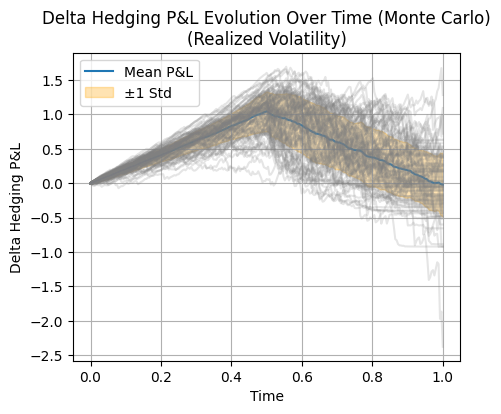

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
S0 = 100      # 初始标的价格
K = 100       # 期权执行价
r = 0.01      # 无风险利率
sigma_iv = 0.2   # 隐含波动率（用于定价和对冲）
T = 1.0       # 到期时间（年）
N = 252      # 对冲步数（交易日）
M = 100      # 蒙特卡洛路径数

dt = T / N

def bs_delta(S, K, r, sigma, tau):
    """欧式看涨期权BS Delta，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    delta = norm.cdf(d1)
    # 到期时，S > K 为1，否则为0
    if S.ndim == 2:
        delta = np.where(tau > 0, delta, (S > K).astype(float))
    else:
        delta = np.where(tau > 0, delta, 1.0 * (S > K))
    return delta

def bs_price(S, K, r, sigma, tau):
    """欧式看涨期权BS价格，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    d2 = d1 - sigma * np.sqrt(np.maximum(tau, 0))
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    price = np.where(tau > 0, price, np.maximum(S - K, 0))
    return price

# 蒙特卡洛模拟（矩阵化）
# 1. 生成所有路径（使用分段realized volatility）
# 前半年（126步）sigma1 = sqrt(0.02)，后半年（126步）sigma2 = sqrt(0.06)
sigma1 = np.sqrt(0.02)
sigma2 = np.sqrt(0.06)
sigma_realized_steps = np.concatenate([np.full(N//2, sigma1), np.full(N - N//2, sigma2)])  # shape (N,)

Z = np.random.randn(M, N)
increments = (r - 0.5 * sigma_realized_steps**2) * dt + sigma_realized_steps * np.sqrt(dt) * Z
log_S = np.cumsum(increments, axis=1)
log_S = np.concatenate([np.zeros((M,1)), log_S], axis=1)
S_paths = S0 * np.exp(log_S)  # shape (M, N+1)

# 2. 计算每个时间点的tau
taus = T - np.arange(N+1) * dt  # shape (N+1,)

# 3. 计算每个路径、每个时间点的delta（用realized volatility，分段）
# 这里每个时间点的sigma_realized不同，需构造shape为(N+1,)的sigma_realized_time
# 剩余到期时间的realized volatility: sqrt(剩余total variance / 剩余到期时间)
# 先构造每步的variance
var1 = sigma1**2
var2 = sigma2**2
# 每步的variance数组
var_steps = np.concatenate([np.full(N//2, var1), np.full(N - N//2, var2)])  # shape (N,)
# 剩余total variance: 对每个时间点，sum后面所有步的variance
total_var_remaining = np.array([np.sum(var_steps[i:])*dt for i in range(N)])  # shape (N,)
# 最后一个点（到期）total variance为0
total_var_remaining = np.append(total_var_remaining, 0.0)  # shape (N+1,)
# 剩余到期时间
tau_grid = T - np.arange(N+1) * dt  # shape (N+1,)
# realized volatility at each time: sqrt(total_var_remaining / tau_grid)
# 注意tau_grid最后一个为0，避免除零
sigma_realized_time = np.zeros(N+1)
with np.errstate(divide='ignore', invalid='ignore'):
    sigma_realized_time[:-1] = np.sqrt(total_var_remaining[:-1] / tau_grid[:-1])
    sigma_realized_time[-1] = sigma2  # 到期时vol为0
# 由于N为偶数，N//2+1+N-N//2 = N+1
deltas = bs_delta(S_paths, K, r, sigma_realized_time, taus)  # shape (M, N+1)

# 4. 初始现金流（用隐含波动率定价）
init_option_price = bs_price(S0, K, r, sigma_iv, T)
init_delta = deltas[:, 0]
cash = np.full(M, init_option_price) - init_delta * S0  # shape (M,)

# 5. 逐步对冲，记录每一步的现金头寸和P&L
cash_steps = np.zeros((M, N+1))
pnl_steps = np.zeros((M, N+1))

cash_steps[:, 0] = cash
pnl_steps[:, 0] = 0

def bs_gamma(S, K, r, sigma, tau):
    """欧式看涨期权BS Gamma，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    gamma = np.where(
        tau > 0,
        norm.pdf(d1) / (S * sigma * np.sqrt(tau)),
        0.0
    )
    return gamma


for t in range(1, N+1):
    # delta变化量
    d_delta = deltas[:, t] - deltas[:, t-1]
    # 买入/卖出股票的现金流
    cash -= d_delta * S_paths[:, t]
    # 现金头寸复利
    cash = cash * np.exp(r * dt)
    # 当前持有股票
    shares = deltas[:, t]
    # 当前现金+股票-期权理论价值（用隐含波动率定价）
    option_value = bs_price(S_paths[:, t], K, r, sigma_iv, taus[t])
    pnl = cash + shares * S_paths[:, t] - option_value
    cash_steps[:, t] = cash
    pnl_steps[:, t] = pnl

# 画出P&L随时间变化的图
mean_pnl = np.mean(pnl_steps, axis=0)
std_pnl = np.std(pnl_steps, axis=0)
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(5,4))
plt.plot(time_grid, mean_pnl, label='Mean P&L')
plt.plot(time_grid, pnl_steps.T, color='gray', alpha=0.2)
plt.fill_between(time_grid, mean_pnl-std_pnl, mean_pnl+std_pnl, color='orange', alpha=0.3, label='±1 Std')
plt.xlabel('Time')
plt.ylabel('Delta Hedging P&L')
plt.title('Delta Hedging P&L Evolution Over Time (Monte Carlo)\n(Realized Volatility)')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\1510295077.py:22: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\1510295077.py:39: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),


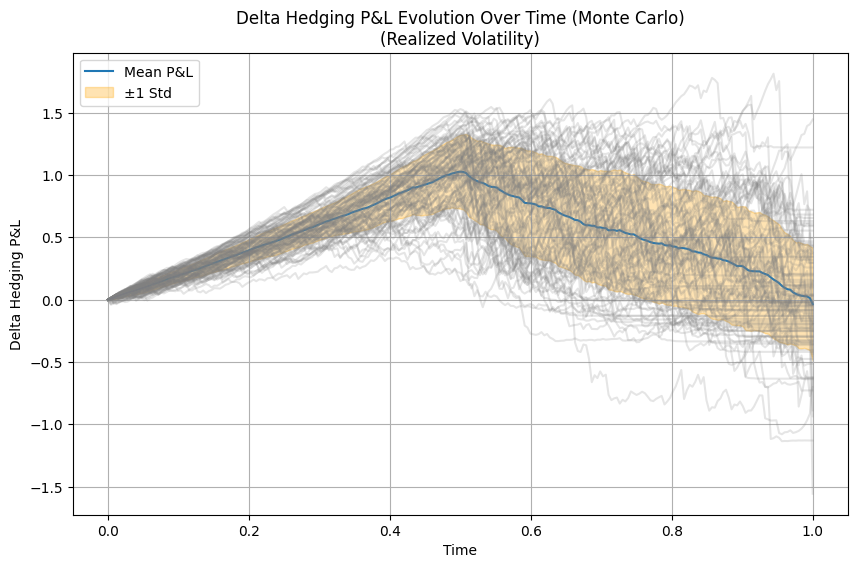

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
S0 = 100      # 初始标的价格
K = 100       # 期权执行价
r = 0.01      # 无风险利率
sigma_iv = 0.2   # 隐含波动率（用于定价和对冲）
T = 1.0       # 到期时间（年）
N = 252      # 对冲步数（交易日）
M = 100      # 蒙特卡洛路径数

dt = T / N

def bs_delta(S, K, r, sigma, tau):
    """欧式看涨期权BS Delta，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    delta = norm.cdf(d1)
    # 到期时，S > K 为1，否则为0
    if S.ndim == 2:
        delta = np.where(tau > 0, delta, (S > K).astype(float))
    else:
        delta = np.where(tau > 0, delta, 1.0 * (S > K))
    return delta

def bs_price(S, K, r, sigma, tau):
    """欧式看涨期权BS价格，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    d2 = d1 - sigma * np.sqrt(np.maximum(tau, 0))
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    price = np.where(tau > 0, price, np.maximum(S - K, 0))
    return price

# 蒙特卡洛模拟（矩阵化）
# 1. 生成所有路径（使用分段realized volatility）
# 前半年（126步）sigma1 = sqrt(0.02)，后半年（126步）sigma2 = sqrt(0.06)
sigma1 = np.sqrt(0.02)
sigma2 = np.sqrt(0.06)
sigma_realized_steps = np.concatenate([np.full(N//2, sigma1), np.full(N - N//2, sigma2)])  # shape (N,)

Z = np.random.randn(M, N)
increments = (r - 0.5 * sigma_realized_steps**2) * dt + sigma_realized_steps * np.sqrt(dt) * Z
log_S = np.cumsum(increments, axis=1)
log_S = np.concatenate([np.zeros((M,1)), log_S], axis=1)
S_paths = S0 * np.exp(log_S)  # shape (M, N+1)

# 2. 计算每个时间点的tau
taus = T - np.arange(N+1) * dt  # shape (N+1,)

# 3. 计算每个路径、每个时间点的delta（用realized volatility，分段）
# 这里每个时间点的sigma_realized不同，需构造shape为(N+1,)的sigma_realized_time
# 剩余到期时间的realized volatility: sqrt(剩余total variance / 剩余到期时间)
# 先构造每步的variance
var1 = sigma1**2
var2 = sigma2**2
# 每步的variance数组
var_steps = np.concatenate([np.full(N//2, var1), np.full(N - N//2, var2)])  # shape (N,)
std_all = np.sqrt(np.append(var_steps, 0.06))
# 剩余total variance: 对每个时间点，sum后面所有步的variance
total_var_remaining = np.array([np.sum(var_steps[i:])*dt for i in range(N)])  # shape (N,)
# 最后一个点（到期）total variance为0
total_var_remaining = np.append(total_var_remaining, 0.0)  # shape (N+1,)
# 剩余到期时间
tau_grid = T - np.arange(N+1) * dt  # shape (N+1,)
# realized volatility at each time: sqrt(total_var_remaining / tau_grid)
# 注意tau_grid最后一个为0，避免除零
sigma_realized_time = np.zeros(N+1)
with np.errstate(divide='ignore', invalid='ignore'):
    sigma_realized_time[:-1] = np.sqrt(total_var_remaining[:-1] / tau_grid[:-1])
    sigma_realized_time[-1] = sigma2  # 到期时vol为0
# 由于N为偶数，N//2+1+N-N//2 = N+1
deltas = bs_delta(S_paths, K, r, sigma_realized_time, taus)  # shape (M, N+1)

# 4. 初始现金流（用隐含波动率定价）
init_option_price = bs_price(S0, K, r, sigma_iv, T)
init_delta = deltas[:, 0]
cash = np.full(M, init_option_price) - init_delta * S0  # shape (M,)

# 5. 逐步对冲，记录每一步的现金头寸和P&L
cash_steps = np.zeros((M, N+1))
pnl_steps = np.zeros((M, N+1))

cash_steps[:, 0] = cash
pnl_steps[:, 0] = 0

def bs_gamma(S, K, r, sigma, tau):
    """欧式看涨期权BS Gamma，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    gamma = np.where(
        tau > 0,
        norm.pdf(d1) / (S * sigma * np.sqrt(tau)),
        0.0
    )
    return gamma


for t in range(1, N+1):
    # delta变化量
    d_delta = deltas[:, t] - deltas[:, t-1]
    # 买入/卖出股票的现金流
    cash -= d_delta * S_paths[:, t]
    # 现金头寸复利
    cash = cash * np.exp(r * dt)
    # 当前持有股票
    shares = deltas[:, t]
    # 当前现金+股票-期权理论价值（用隐含波动率定价）
    option_value = bs_price(S_paths[:, t], K, r, sigma_iv, taus[t])
    pnl = cash + shares * S_paths[:, t] - option_value
    cash_steps[:, t] = cash
    pnl_steps[:, t] = pnl

# 画出P&L随时间变化的图
mean_pnl = np.mean(pnl_steps, axis=0)
std_pnl = np.std(pnl_steps, axis=0)
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(10,6))
plt.plot(time_grid, mean_pnl, label='Mean P&L')
plt.plot(time_grid, pnl_steps.T, color='gray', alpha=0.2)
plt.fill_between(time_grid, mean_pnl-std_pnl, mean_pnl+std_pnl, color='orange', alpha=0.3, label='±1 Std')
plt.xlabel('Time')
plt.ylabel('Delta Hedging P&L')
plt.title('Delta Hedging P&L Evolution Over Time (Monte Carlo)\n(Realized Volatility)')
plt.legend()
plt.grid(True)
plt.show()

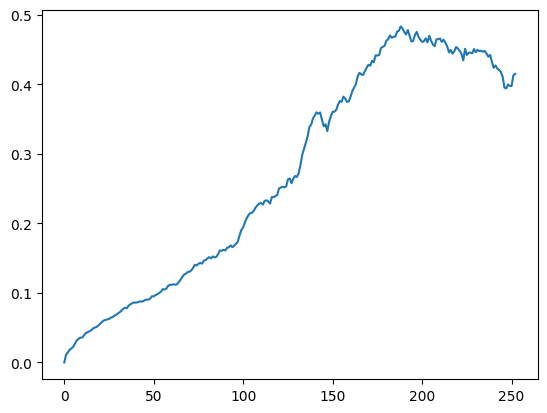

In [23]:
plt.plot(pnl_steps.std(axis=0))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\1309738578.py:104: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\1309738578.py:109: RuntimeWarning: divide by zero encountered in divide
  norm.pdf(d1) / (S * sigma * np.sqrt(tau)),


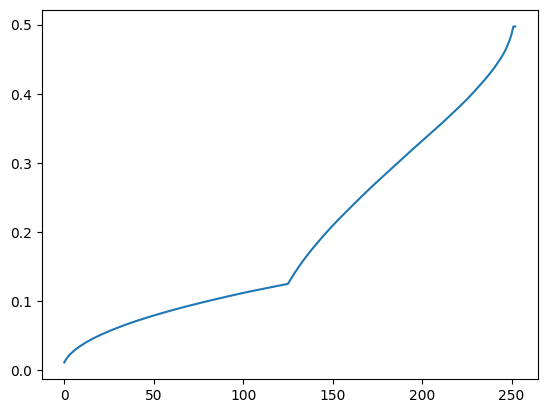

In [24]:
gamma_path = bs_gamma(S_paths, K, r, sigma_realized_time, taus)  # shape (M, N+1)

Error_path = (1/2)*((np.append(var_steps, 0.06))**2)*(gamma_path**2)*(S_paths**4)*(dt**2)
Error_path = Error_path.cumsum(axis=1)
# Error_path.mean(axis=0).cumsum()
plt.plot(np.sqrt(Error_path.mean(axis=0)))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\2037941689.py:22: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\2037941689.py:39: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),


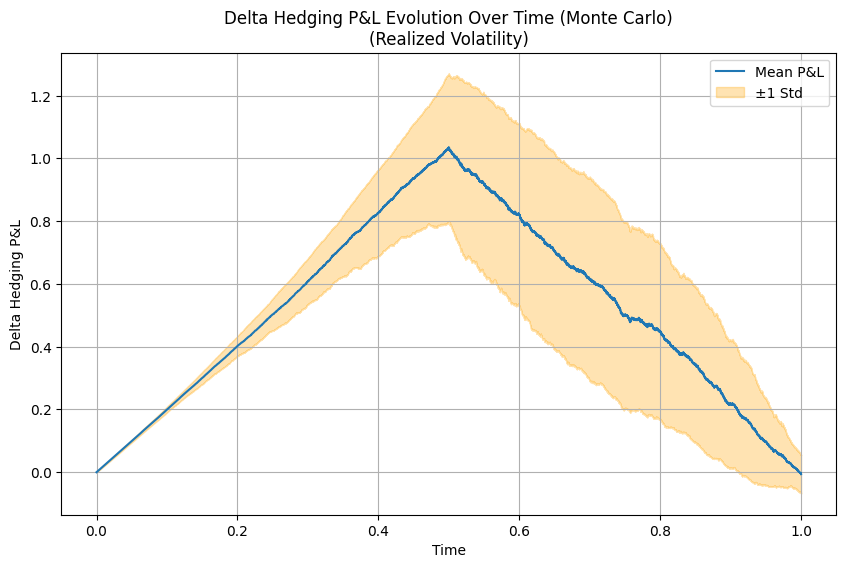

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
S0 = 100      # 初始标的价格
K = 100       # 期权执行价
r = 0.01      # 无风险利率
sigma_iv = 0.2   # 隐含波动率（用于定价和对冲）
T = 1.0       # 到期时间（年）
N = 25200      # 对冲步数（交易日）
M = 100      # 蒙特卡洛路径数

dt = T / N

def bs_delta(S, K, r, sigma, tau):
    """欧式看涨期权BS Delta，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    delta = norm.cdf(d1)
    # 到期时，S > K 为1，否则为0
    if S.ndim == 2:
        delta = np.where(tau > 0, delta, (S > K).astype(float))
    else:
        delta = np.where(tau > 0, delta, 1.0 * (S > K))
    return delta

def bs_price(S, K, r, sigma, tau):
    """欧式看涨期权BS价格，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    d2 = d1 - sigma * np.sqrt(np.maximum(tau, 0))
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    price = np.where(tau > 0, price, np.maximum(S - K, 0))
    return price

# 蒙特卡洛模拟（矩阵化）
# 1. 生成所有路径（使用分段realized volatility）
# 前半年（126步）sigma1 = sqrt(0.02)，后半年（126步）sigma2 = sqrt(0.06)
sigma1 = np.sqrt(0.02)
sigma2 = np.sqrt(0.06)
sigma_realized_steps = np.concatenate([np.full(N//2, sigma1), np.full(N - N//2, sigma2)])  # shape (N,)

Z = np.random.randn(M, N)
increments = (r - 0.5 * sigma_realized_steps**2) * dt + sigma_realized_steps * np.sqrt(dt) * Z
log_S = np.cumsum(increments, axis=1)
log_S = np.concatenate([np.zeros((M,1)), log_S], axis=1)
S_paths = S0 * np.exp(log_S)  # shape (M, N+1)

# 2. 计算每个时间点的tau
taus = T - np.arange(N+1) * dt  # shape (N+1,)

# 3. 计算每个路径、每个时间点的delta（用realized volatility，分段）
# 这里每个时间点的sigma_realized不同，需构造shape为(N+1,)的sigma_realized_time
# 剩余到期时间的realized volatility: sqrt(剩余total variance / 剩余到期时间)
# 先构造每步的variance
var1 = sigma1**2
var2 = sigma2**2
# 每步的variance数组
var_steps = np.concatenate([np.full(N//2, var1), np.full(N - N//2, var2)])  # shape (N,)
std_all = np.sqrt(np.append(var_steps, 0.06))
# 剩余total variance: 对每个时间点，sum后面所有步的variance
total_var_remaining = np.array([np.sum(var_steps[i:])*dt for i in range(N)])  # shape (N,)
# 最后一个点（到期）total variance为0
total_var_remaining = np.append(total_var_remaining, 0.0)  # shape (N+1,)
# 剩余到期时间
tau_grid = T - np.arange(N+1) * dt  # shape (N+1,)
# realized volatility at each time: sqrt(total_var_remaining / tau_grid)
# 注意tau_grid最后一个为0，避免除零
sigma_realized_time = np.zeros(N+1)
with np.errstate(divide='ignore', invalid='ignore'):
    sigma_realized_time[:-1] = np.sqrt(total_var_remaining[:-1] / tau_grid[:-1])
    sigma_realized_time[-1] = sigma2  # 到期时vol为0
# 由于N为偶数，N//2+1+N-N//2 = N+1
deltas = bs_delta(S_paths, K, r, sigma_realized_time, taus)  # shape (M, N+1)

# 4. 初始现金流（用隐含波动率定价）
init_option_price = bs_price(S0, K, r, sigma_iv, T)
init_delta = deltas[:, 0]
cash = np.full(M, init_option_price) - init_delta * S0  # shape (M,)

# 5. 逐步对冲，记录每一步的现金头寸和P&L
cash_steps = np.zeros((M, N+1))
pnl_steps = np.zeros((M, N+1))

cash_steps[:, 0] = cash
pnl_steps[:, 0] = 0

def bs_gamma(S, K, r, sigma, tau):
    """欧式看涨期权BS Gamma，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    gamma = np.where(
        tau > 0,
        norm.pdf(d1) / (S * sigma * np.sqrt(tau)),
        0.0
    )
    return gamma


for t in range(1, N+1):
    # delta变化量
    d_delta = deltas[:, t] - deltas[:, t-1]
    # 买入/卖出股票的现金流
    cash -= d_delta * S_paths[:, t]
    # 现金头寸复利
    cash = cash * np.exp(r * dt)
    # 当前持有股票
    shares = deltas[:, t]
    # 当前现金+股票-期权理论价值（用隐含波动率定价）
    option_value = bs_price(S_paths[:, t], K, r, sigma_iv, taus[t])
    pnl = cash + shares * S_paths[:, t] - option_value
    cash_steps[:, t] = cash
    pnl_steps[:, t] = pnl

# 画出P&L随时间变化的图
mean_pnl = np.mean(pnl_steps, axis=0)
std_pnl = np.std(pnl_steps, axis=0)
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(10,6))
plt.plot(time_grid, mean_pnl, label='Mean P&L')
#plt.plot(time_grid, pnl_steps.T, color='gray', alpha=0.2)
plt.fill_between(time_grid, mean_pnl-std_pnl, mean_pnl+std_pnl, color='orange', alpha=0.3, label='±1 Std')
plt.xlabel('Time')
plt.ylabel('Delta Hedging P&L')
plt.title('Delta Hedging P&L Evolution Over Time (Monte Carlo)\n(Realized Volatility)')
plt.legend()
plt.grid(True)
plt.show()

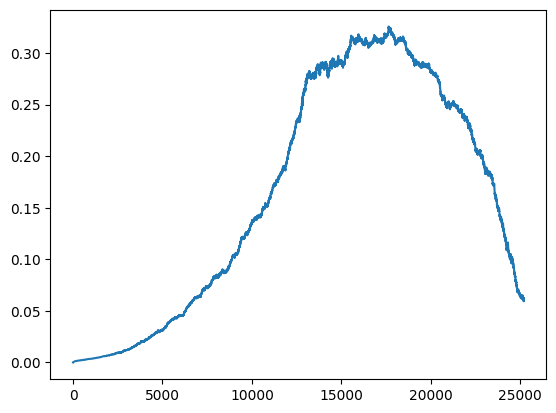

In [105]:
plt.plot(pnl_steps.std(axis=0))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\2037941689.py:105: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_21180\2037941689.py:110: RuntimeWarning: divide by zero encountered in divide
  norm.pdf(d1) / (S * sigma * np.sqrt(tau)),


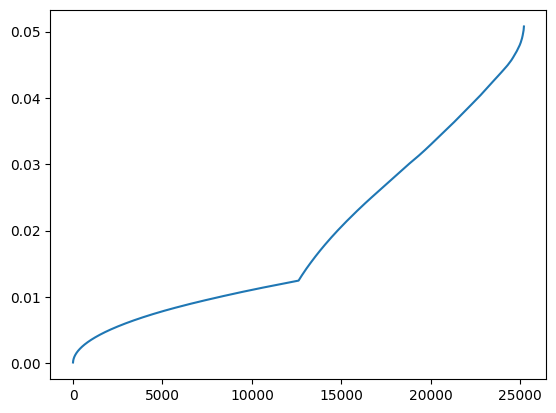

In [106]:
gamma_path = bs_gamma(S_paths, K, r, sigma_realized_time, taus)  # shape (M, N+1)

Error_path = (1/2)*((np.append(var_steps, 0.06))**2)*(gamma_path**2)*(S_paths**4)*(dt**2)
Error_path = Error_path.cumsum(axis=1)
# Error_path.mean(axis=0).cumsum()
plt.plot(np.sqrt(Error_path.mean(axis=0)))

C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\3649398607.py:22: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\3649398607.py:39: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),


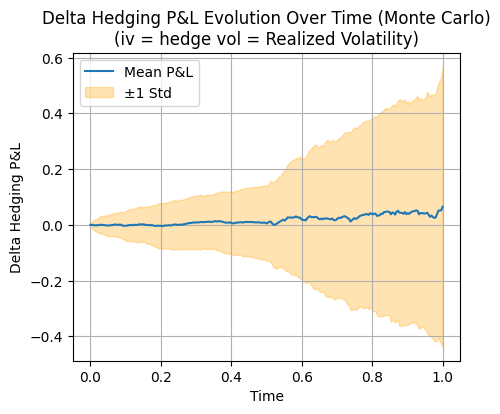

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 参数设置
S0 = 100      # 初始标的价格
K = 100       # 期权执行价
r = 0.01      # 无风险利率
sigma_iv = 0.2   # 隐含波动率（用于定价和对冲）
T = 1.0       # 到期时间（年）
N = 252      # 对冲步数（交易日）
M = 100      # 蒙特卡洛路径数

dt = T / N

def bs_delta(S, K, r, sigma, tau):
    """欧式看涨期权BS Delta，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    delta = norm.cdf(d1)
    # 到期时，S > K 为1，否则为0
    if S.ndim == 2:
        delta = np.where(tau > 0, delta, (S > K).astype(float))
    else:
        delta = np.where(tau > 0, delta, 1.0 * (S > K))
    return delta

def bs_price(S, K, r, sigma, tau):
    """欧式看涨期权BS价格，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    d2 = d1 - sigma * np.sqrt(np.maximum(tau, 0))
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    price = np.where(tau > 0, price, np.maximum(S - K, 0))
    return price

# 蒙特卡洛模拟（矩阵化）
# 1. 生成所有路径（使用分段realized volatility）
# 前半年（126步）sigma1 = sqrt(0.02)，后半年（126步）sigma2 = sqrt(0.06)
sigma1 = np.sqrt(0.02)
sigma2 = np.sqrt(0.06)
sigma_realized_steps = np.concatenate([np.full(N//2, sigma1), np.full(N - N//2, sigma2)])  # shape (N,)

Z = np.random.randn(M, N)
increments = (r - 0.5 * sigma_realized_steps**2) * dt + sigma_realized_steps * np.sqrt(dt) * Z
log_S = np.cumsum(increments, axis=1)
log_S = np.concatenate([np.zeros((M,1)), log_S], axis=1)
S_paths = S0 * np.exp(log_S)  # shape (M, N+1)

# 2. 计算每个时间点的tau
taus = T - np.arange(N+1) * dt  # shape (N+1,)

# 3. 计算每个路径、每个时间点的delta（用realized volatility，分段）
# 这里每个时间点的sigma_realized不同，需构造shape为(N+1,)的sigma_realized_time
# 剩余到期时间的realized volatility: sqrt(剩余total variance / 剩余到期时间)
# 先构造每步的variance
var1 = sigma1**2
var2 = sigma2**2
# 每步的variance数组
var_steps = np.concatenate([np.full(N//2, var1), np.full(N - N//2, var2)])  # shape (N,)
std_all = np.sqrt(np.append(var_steps, 0.06))
# 剩余total variance: 对每个时间点，sum后面所有步的variance
total_var_remaining = np.array([np.sum(var_steps[i:])*dt for i in range(N)])  # shape (N,)
# 最后一个点（到期）total variance为0
total_var_remaining = np.append(total_var_remaining, 0.0)  # shape (N+1,)
# 剩余到期时间
tau_grid = T - np.arange(N+1) * dt  # shape (N+1,)
# realized volatility at each time: sqrt(total_var_remaining / tau_grid)
# 注意tau_grid最后一个为0，避免除零
sigma_realized_time = np.zeros(N+1)
with np.errstate(divide='ignore', invalid='ignore'):
    sigma_realized_time[:-1] = np.sqrt(total_var_remaining[:-1] / tau_grid[:-1])
    sigma_realized_time[-1] = sigma2  # 到期时vol为0
# 由于N为偶数，N//2+1+N-N//2 = N+1
deltas = bs_delta(S_paths, K, r, sigma_realized_time, taus)  # shape (M, N+1)

# 4. 初始现金流（用隐含波动率定价）
init_option_price = bs_price(S0, K, r, sigma_iv, T)
init_delta = deltas[:, 0]
cash = np.full(M, init_option_price) - init_delta * S0  # shape (M,)

# 5. 逐步对冲，记录每一步的现金头寸和P&L
cash_steps = np.zeros((M, N+1))
pnl_steps = np.zeros((M, N+1))

cash_steps[:, 0] = cash
pnl_steps[:, 0] = 0

def bs_gamma(S, K, r, sigma, tau):
    """欧式看涨期权BS Gamma，支持向量化"""
    S = np.asarray(S)
    tau = np.asarray(tau)
    d1 = np.where(
        tau > 0,
        (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
        0
    )
    gamma = np.where(
        tau > 0,
        norm.pdf(d1) / (S * sigma * np.sqrt(tau)),
        0.0
    )
    return gamma


for t in range(1, N+1):
    # delta变化量
    d_delta = deltas[:, t] - deltas[:, t-1]
    # 买入/卖出股票的现金流
    cash -= d_delta * S_paths[:, t]
    # 现金头寸复利
    cash = cash * np.exp(r * dt)
    # 当前持有股票
    shares = deltas[:, t]
    # 当前现金+股票-期权理论价值（用隐含波动率定价）
    option_value = bs_price(S_paths[:, t], K, r, sigma_realized_time[t], taus[t])
    pnl = cash + shares * S_paths[:, t] - option_value
    cash_steps[:, t] = cash
    pnl_steps[:, t] = pnl

# 画出P&L随时间变化的图
mean_pnl = np.mean(pnl_steps, axis=0)
std_pnl = np.std(pnl_steps, axis=0)
time_grid = np.linspace(0, T, N+1)

plt.figure(figsize=(5,4))
plt.plot(time_grid, mean_pnl, label='Mean P&L')
#plt.plot(time_grid, pnl_steps.T, color='gray', alpha=0.2)
plt.fill_between(time_grid, mean_pnl-std_pnl, mean_pnl+std_pnl, color='orange', alpha=0.3, label='±1 Std')
plt.xlabel('Time')
plt.ylabel('Delta Hedging P&L')
plt.title('Delta Hedging P&L Evolution Over Time (Monte Carlo)\n(iv = hedge vol = Realized Volatility)')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'Delta Hedging P&L Std Over Time (N=252))')

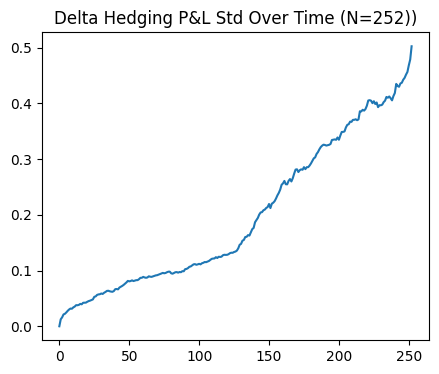

In [37]:
plt.figure(figsize=(5, 4))
plt.plot(pnl_steps.std(axis=0))
plt.title(f"Delta Hedging P&L Std Over Time (N=252))")


C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\3649398607.py:105: RuntimeWarning: divide by zero encountered in divide
  (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau)),
C:\Users\ASUS\AppData\Local\Temp\ipykernel_23300\3649398607.py:110: RuntimeWarning: divide by zero encountered in divide
  norm.pdf(d1) / (S * sigma * np.sqrt(tau)),


Text(0.5, 1.0, 'Error Process sqrt(Var) Over Time (N=252))')

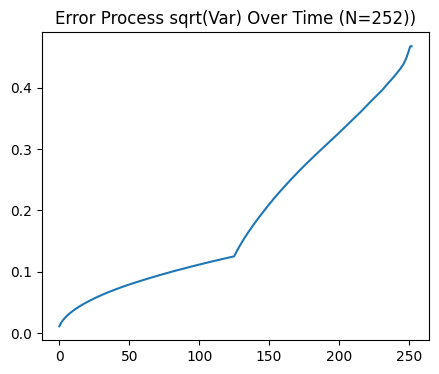

In [38]:
gamma_path = bs_gamma(S_paths, K, r, sigma_realized_time, taus)  # shape (M, N+1)

Error_path = (1/2)*((np.append(var_steps, 0.06))**2)*(gamma_path**2)*(S_paths**4)*(dt**2)
Error_path = Error_path.cumsum(axis=1)
# Error_path.mean(axis=0).cumsum()
plt.figure(figsize=(5, 4))
plt.plot(np.sqrt(Error_path.mean(axis=0)))
plt.title(f"Error Process sqrt(Var) Over Time (N=252))")